In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys
from os.path import join as oj
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('sketch')
# plt.style.use('publication')
plt.style.use('custom_five')
import configparser
import pandas as pd
import pickle as pkl
config = configparser.ConfigParser()
config.read('../config.ini');
model_path =config["PATHS"]["model_unet_path"]
fig_path = config["PATHS"]["fig_path"]


In [2]:
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()
# results = results[results.exp_name == 'PhaseFieldPrediction']
# results.reset_index(inplace=True)

In [15]:
results_split = results[results['tag'] == 'startOffset']
results_split = results_split[results_split.start_offset == 10]
results_split = results_split[results_split['split_accs'].notna()]

In [16]:
dict_list = []
for i in range(results_split.shape[0]):
    dict_list.append(results_split.iloc[i]['split_accs'])

In [17]:
my_keys = dict_list[0].keys()
results_split_ff = {}
for key in my_keys:
    results_split_ff[key] = [d[key] for d in dict_list]
# results_split_ff[160] = [results_split.iloc[i]['ood_prediction_err'] for i in range(len(results_split))]

In [18]:
results_split_ff_key_list = list(results_split_ff.keys())
res_error = [np.asarray(x).mean() for x in list(results_split_ff.values())]
res_std = [np.asarray(x).std() for x in list(results_split_ff.values())]


In [19]:
ood_error = [results_split.iloc[i]['ood_prediction_err'] for i in range(len(results_split))]

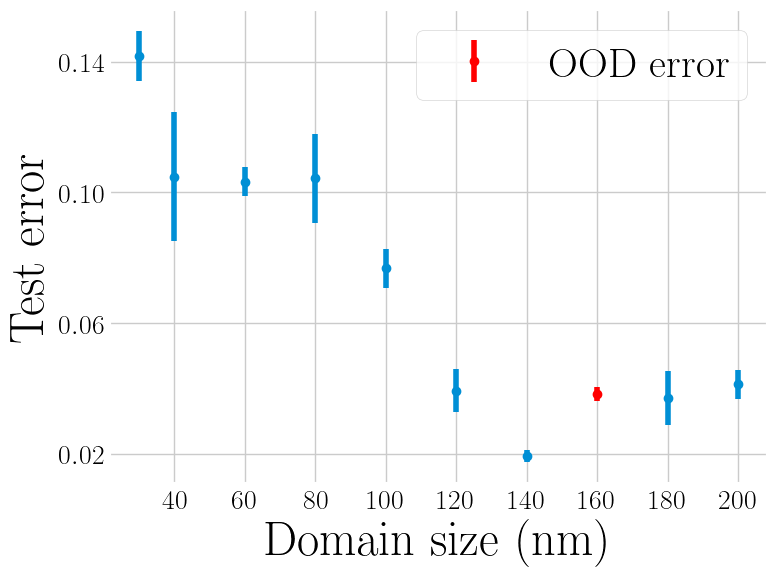

In [20]:
# scatter with error bars
fontsize_labels = 35
fontsize_ticks = 20
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(results_split_ff_key_list, res_error, yerr=res_std, fmt='o')

plt.ylabel('Test error', fontsize=fontsize_labels)
plt.xlabel('Domain size (nm)', fontsize=fontsize_labels)

plt.errorbar([160,] , [np.mean(ood_error),],yerr = [np.std(ood_error),], color='r', fmt='o', label='OOD error')
# plt.xticks(results_split_ff_key_list + [160, 60], fontsize=20)
plt.xticks([40, 60, 80,100, 120, 140, 160, 180, 200] ,fontsize=fontsize_ticks)
plt.yticks([.02, .06, .10, .14],fontsize=fontsize_ticks)

import matplotlib.ticker as ticker
# minor_locator = ticker.MultipleLocator(20)
ax.xaxis.set_minor_locator(MultipleLocator(5))
plt.legend(fontsize=fontsize_labels-5, loc='upper right')
plt.tight_layout()
plt.savefig(oj(fig_path, 'domain_size_vs_error.pdf'))

In [17]:
results_architecture = results[(results.tag == 'architecture') + ((results.tag == 'train_percentage') *(results.train_percentage == 1.0)) ].copy()


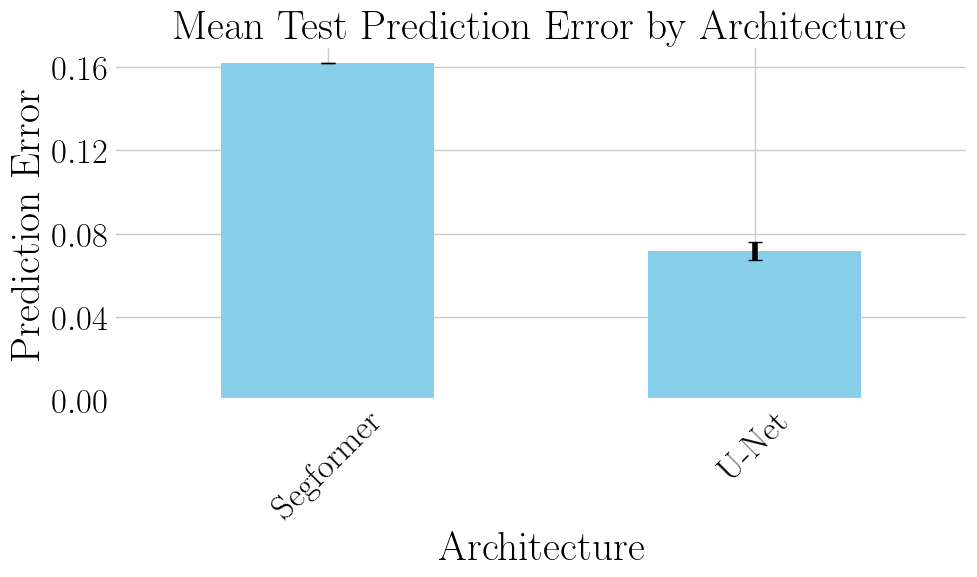

In [75]:
# make a bar plot
fontsize_labels = 30
fontsize_ticks = 25
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Grouping results by architecture and calculating the mean test prediction error
# rename test_prediction_err to Test Prediction Error
results_architecture.rename(columns={'test_prediction_err': 'Test Prediction Error'}, inplace=True)
results_architecture_grouped = results_architecture.groupby('architecture')['Test Prediction Error'].mean()

results_architecture_grouped = results_architecture.groupby('architecture')['Test Prediction Error']
mean_error = results_architecture_grouped.mean()
std_error = results_architecture_grouped.std()
n_samples = results_architecture_grouped.count()

# Plotting the bar chart with error bars
mean_error.plot(kind='bar', ax=ax, yerr=std_error / (n_samples ** 0.5), capsize=5, color='skyblue')

# Adding labels and title
ax.set_xlabel('Architecture', fontsize=fontsize_labels)
ax.set_ylabel('Prediction Error', fontsize=fontsize_labels)
ax.set_title('Mean Test Prediction Error by Architecture', fontsize=fontsize_labels)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, fontsize=fontsize_ticks)
# make xticks larger
plt.yticks([.0, .04, .08, .12, .16],fontsize=fontsize_ticks)
# Displaying the plot
plt.tight_layout()

# plt.legend()
plt.savefig(oj(fig_path, 'architectures.pdf'))

In [19]:
# results_architecture[['architecture', 'test_prediction_err']].groupby('architecture').mean()

In [20]:
my_res = results[(results.loss == 'bce') + ((results.tag == 'train_percentage') *(results.train_percentage == 1.0)) ].copy()

my_res = my_res[['test_prediction_err','ood_prediction_err', 'seed', 'loss' ]]
# delete with nan
my_res = my_res[~my_res.test_prediction_err.isna()]
my_res = my_res[~my_res.ood_prediction_err.isna()]
# now combine with different loss as different columns
my_res = my_res.pivot(index='seed', columns='loss', values=['test_prediction_err','ood_prediction_err'])
my_res = my_res['test_prediction_err']

In [21]:
# # not needed as of now, doesn't really add anything

# import seaborn as sns

# # relabel the name of the columns
# my_res.rename(columns={'bce': 'BCE', 'mse': 'MSE', }, inplace=True)

# names = ['BCE', 'MSE']
# my_tab = np.asarray(my_res.mean())
# my_std = np.asarray(my_res.std())
# # matplotlib barplot
# fig, ax = plt.subplots(figsize=(8, 6))
# plt.ylabel("Testset error")
# plt.ylabel("Loss function")
# # two different colors
# ax.bar(names, my_tab, yerr=my_std, )

# # my_tab.plot.bar(yerr=my_std, ax=ax, )
# plt.savefig(oj(config["PATHS"]["fig_path"], "loss_err.pdf"), )

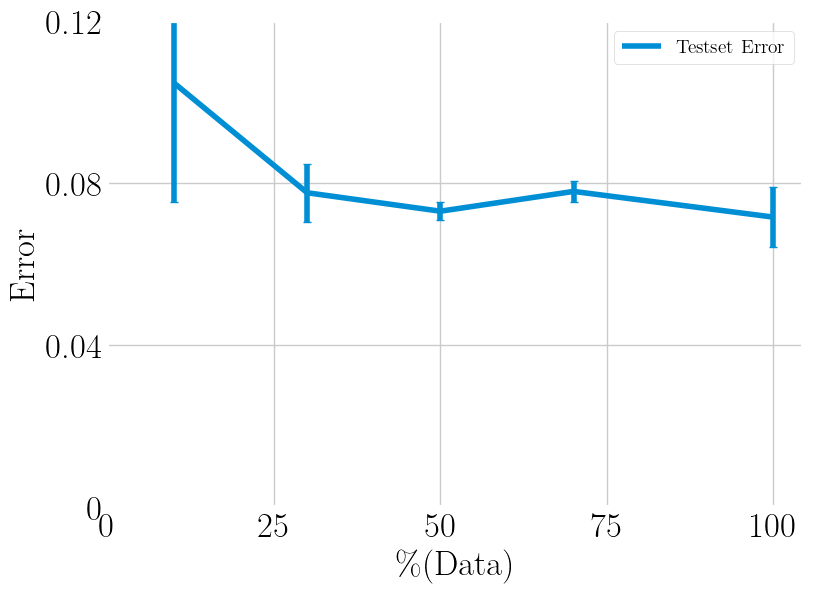

In [22]:
my_res = results[results.tag == 'train_percentage'].copy()
# relabel the name of the columns
my_res.rename(columns={'test_prediction_err': 'Testset Error',  'train_percentage': '% Data'}, inplace=True)


my_tab = my_res[['Testset Error',  '% Data']].groupby(['% Data']).mean()
my_std = my_res[['Testset Error',  '% Data']].groupby(['% Data']).std()
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
my_tab.plot(ax=axes, yerr=my_std, capsize=3, )
axes.set_ylabel('Error', fontsize=25)
axes.set_xlabel('\%(Data)', fontsize=25)
axes.set_ylim([0, 0.12])
axes.set_yticks([0, 0.04,  0.08, .12], [0, .04, .08, .12,], fontsize=25)
axes.set_xticks([0, 0.25, 0.5, .75, 1], [0,25, 50,75, 100], fontsize = 25)
# axes.set_title('Prediction offset vs absolute error')
# plt.savefig(oj(config["PATHS"]["fig_path"], "percentage_err.pdf"), )

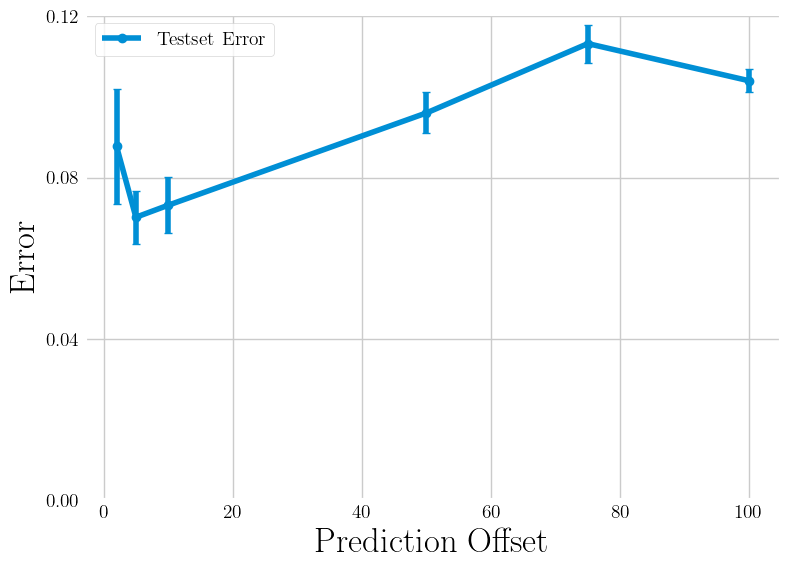

In [35]:
# relabel the name of the columns
results_offset = results[results.tag == "predictionOffset"].copy()
results_offset.rename(columns={'test_prediction_err': 'Testset Error',  'prediction_offset': 'Prediction Offset'}, inplace=True)


my_tab = results_offset[['Testset Error',  'Prediction Offset']].groupby(['Prediction Offset']).mean()
my_std = results_offset[['Testset Error',  'Prediction Offset']].groupby(['Prediction Offset']).std()
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
my_tab.plot(ax=axes, yerr=my_std, capsize=3, marker='o')
axes.set_ylabel('Error', fontsize=25)
axes.set_xlabel('Prediction Offset', fontsize=25)
# axes.set_ylim([0, 0.12])
axes.set_yticks([0, 0.04,  0.08, .12])
# axes.set_title('Prediction offset vs absolute error')
plt.savefig(oj(config["PATHS"]["fig_path"], "offset_err.pdf"), )

In [102]:
results.tag.unique()

array(['predictionOffset', 'startOffset', 'architecture',
       'train_percentage', 'startOffset2'], dtype=object)

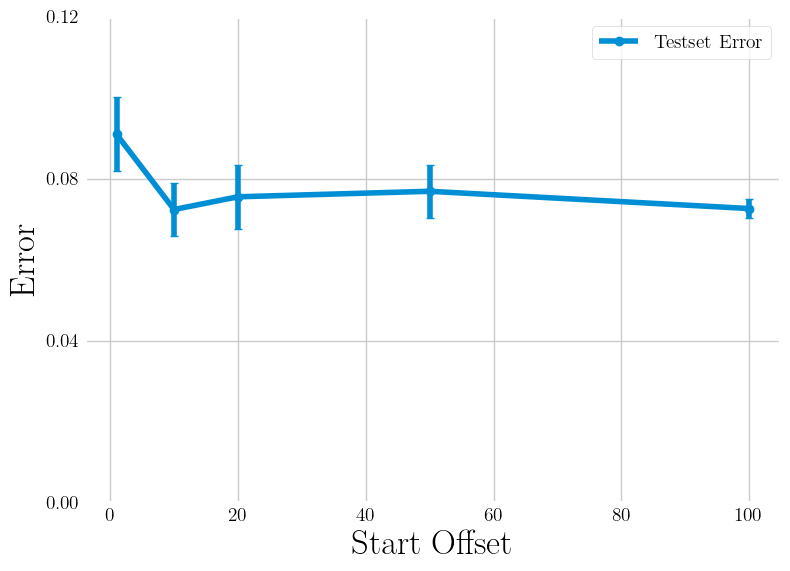

In [24]:
# relabel the name of the columns

results_startoffset = results[results.tag == "startOffset"].copy()
results_startoffset.rename(columns={'test_prediction_err': 'Testset Error',  'start_offset': 'Start Offset'}, inplace=True)


my_tab = results_startoffset[['Testset Error', 'Start Offset']].groupby(['Start Offset']).mean()
my_std = results_startoffset[['Testset Error',  'Start Offset']].groupby(['Start Offset']).std()
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
my_tab.plot(ax=axes, yerr=my_std, capsize=3, marker='o')
axes.set_ylabel('Error', fontsize=25)
axes.set_xlabel('Start Offset', fontsize=25)
# set ylim
axes.set_ylim([0, 0.12])
axes.set_yticks([0, 0.04,  0.08, .12])

# axes.set_title('Prediction offset vs absolute error')
plt.savefig(oj(config["PATHS"]["fig_path"], "startoffset_err.pdf"), )

In [22]:
# training percentage plot


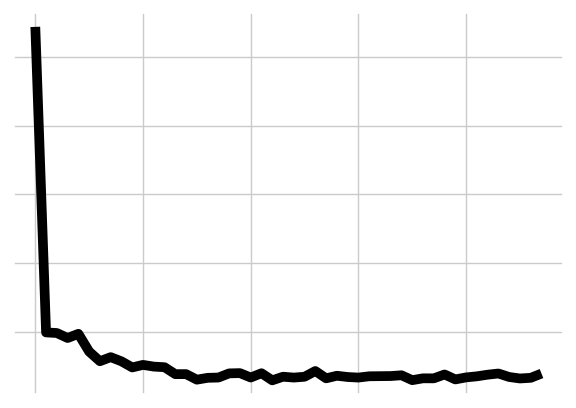

In [23]:

idx = results_startoffset.prediction_err.argmin()
fig, ax = plt.subplots(1, 1)
my_width = 7
ax.plot(results_startoffset.iloc[idx]['train_losses'], c = '0', linewidth=my_width)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(my_width)  # change width
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig(oj(fig_path, 'losses_icon.png'),)